In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kishorekumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kishorekumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as smf

import math 

from sklearn import metrics 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [11]:
from google.colab import drive
df = pd.read_csv('/content/gdrive/My Drive/yelp.csv')
df

ModuleNotFoundError: No module named 'google'

In [0]:
y = pd.get_dummies(df.stars)
print(y.head(3))

   1  2  3  4  5
0  0  0  0  0  1
1  0  0  0  0  1
2  0  0  0  1  0


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [0]:
sns.catplot(kind="count", palette="ch:.25", data=y);

ValueError: ignored

In [0]:
df.groupby('1').size().plot(kind='bar')

KeyError: ignored

In [0]:
#remove newlines in text
def preprocess(text):
    return text.replace('\n\n',' ')

In [0]:
#create list of all reviews with the new line symbols removed
all_reviews = []
for i in df.index:
    all_reviews.append(preprocess(df.text[i]))

In [0]:
#calculate tf-idf
tfidf = TfidfVectorizer()
tfidf_table = tfidf.fit_transform(all_reviews)


In [0]:
n_features = len(tfidf.get_feature_names())
print(n_features)

29185


In [0]:
#save average tf-idf and sum of tf-idf for each review
avg_non_zero_tf_idf =[]
sum_tf_idf =[]
for i in range(len(all_reviews)):
    
    non_zero_doc_tf_idf = tfidf_table[i].tocoo().data.tolist()
    
    if len(non_zero_doc_tf_idf) ==0:
        avg_non_zero_tf_idf.append(0)
        
    else: avg_non_zero_tf_idf.append(sum(non_zero_doc_tf_idf)/len(non_zero_doc_tf_idf))
    
    sum_tf_idf.append(tfidf_table[i].tocoo().data.sum())


In [0]:
#calculate other features for the model

# stop_words=stopwords.words("english")

def is_not_only_punctuation(word):
    return not all([x  in string.punctuation for x in word  ]) 

n_words =[] #number of words
n_sent =[] #number of sentences
for review in all_reviews:
    word_list = nltk.word_tokenize(review)
    word_list_no_puncuation = [word for word in word_list if is_not_only_punctuation(word)]
    n_words.append(len(word_list_no_puncuation))
    n_sent.append( len(nltk.sent_tokenize(review)))
    
n_paras = []  #number of paragraphs
for i in df.index:
     n_paras.append(df.text[i].count("\n\n")+1)
    


In [0]:
#create binary variables for cool, funny, and useful - consider something cool/etc if 2+ votes
df['is_cool']= df.cool>1
df['is_funny']= df.funny>1
df['is_useful']= df.useful>1

#create binary variables for stars
df['star_1']= df.stars == 1
df['star_2']= df.stars == 2
df['star_3']= df.stars == 3
df['star_4']= df.stars == 4
df['star_5']= df.stars == 5

#save other features
df['avg_non_zero_tf_idf'] = avg_non_zero_tf_idf 
df['sum_tf_idf'] = sum_tf_idf
df['n_words']= n_words
df['n_sent']= n_sent
df['n_paras']= n_paras

df['exclaim'] = df.text.str.contains('!')

In [0]:
pip install cufflinks --upgrade

Requirement already up-to-date: cufflinks in /usr/local/lib/python3.6/dist-packages (0.17.0)


In [0]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [0]:
lexical_diversity =[]

for review in all_reviews: 
    word_list = nltk.word_tokenize(review.lower())
    unique_word_list = set(word_list)

    lexical_diversity.append(len(unique_word_list)/len(word_list))    
df['LD']= lexical_diversity


In [0]:
analyzer=SentimentIntensityAnalyzer()

## to account for sentiment, we can include the results from sentinment analysis 
#into the model as features

## try both numerical (positive, negative, neutral scores) or binary
# a review can have a high amount of both positive and negative sentiment, so keep both
# positive and negtive aspects seperate instead of using compound score


neg = []
pos =[]
neu = []
for review in all_reviews:
    sent=analyzer.polarity_scores(review)

    neg.append(sent['neg'])
    pos.append(sent['pos'])
    neu.append(sent['neu'])
    
df['neg']= neg
df['pos']= pos
df['neu']= neu

df['is_neg']= df['neg']>.5
df['is_pos']= df['pos']>.5
df['is_neu']= df['neu']>.5

In [0]:
df['neg'].iplot(
    kind='hist',
    bins=50,
    xTitle='Neg-polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

In [0]:
df['pos'].iplot(
    kind='hist',
    bins=50,
    xTitle='Pos-polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

In [0]:
df['neu'].iplot(
    kind='hist',
    bins=50,
    xTitle='Neu-polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

### Average TF IDF over non zero values (ie only over words in the doc)

through trail and error this is the best model I found, based of R2 of test set 

coefs for cool and useful are (-) and funny is (+)

In [0]:
#split into train and test set 

X = df[['is_pos','is_neg','is_cool','is_funny','is_useful','star_1','star_2','star_3','star_4','star_5','n_sent','n_paras','n_words']]
y = df[['avg_non_zero_tf_idf']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#fit model
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train, y_train)


for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

pred=regression_model.predict(X_test) #make prediction on test set
error = math.sqrt(metrics.mean_squared_error(y_test,pred)) #calculate rmse

print('Test RMSE:: ',error)
print('Test score::',regression_model.score(X_test,y_test)) #R2 score


The coefficient for is_pos is 0.1776610308952805
The coefficient for is_neg is 0.29508945662741454
The coefficient for is_cool is -0.004534872285599778
The coefficient for is_funny is 0.0037141008361668494
The coefficient for is_useful is -0.006841376212065588
The coefficient for star_1 is 0.005164718954332752
The coefficient for star_2 is 0.0013352766978667818
The coefficient for star_3 is -0.0037653422133125847
The coefficient for star_4 is -0.002491458025598286
The coefficient for star_5 is -0.00024319541328987788
The coefficient for n_sent is -0.0007719838666253795
The coefficient for n_paras is 0.000626502083430801
The coefficient for n_words is -0.0002613597650564792
Test RMSE::  0.0448489285742446
Test score:: 0.5815078220074996


### Sum of tf-idf over all words

Cool and useful (+) and funny is (-)

In [0]:
#split into train and test set 

X = df[['is_pos','is_neg','is_cool','is_funny','is_useful','star_1','star_2','star_3','star_4','star_5','n_sent','n_paras','n_words','exclaim']]
y = df[['sum_tf_idf']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#fit model
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train, y_train)


for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

pred=regression_model.predict(X_test) #make prediction on test set
error = math.sqrt(metrics.mean_squared_error(y_test,pred)) #calculate rmse

print('Test RMSE:: ',error)
print('Test score::',regression_model.score(X_test,y_test)) #R2 score


The coefficient for is_pos is -2.308495528134038
The coefficient for is_neg is -2.9591613348514314
The coefficient for is_cool is 0.1252340520850069
The coefficient for is_funny is -0.05584530016855955
The coefficient for is_useful is 0.20616573674201644
The coefficient for star_1 is -0.1824751746333082
The coefficient for star_2 is 0.002957708601380719
The coefficient for star_3 is 0.1410017999193635
The coefficient for star_4 is 0.08445042524997606
The coefficient for star_5 is -0.04593475913740965
The coefficient for n_sent is 0.01362403079992
The coefficient for n_paras is 0.005247852752238158
The coefficient for n_words is 0.018111875685257406
The coefficient for exclaim is 0.1659262288540726
Test RMSE::  1.0519978736939715
Test score:: 0.8253913849237968


### Lexical diversity

Cool and useful (-) and funny is (+)

In [0]:
#split into train and test set 

X = df[['pos','neg','is_cool','is_funny','is_useful','star_1','star_2','star_3','star_4','star_5','n_sent','n_paras','n_words']]
y = df[['LD']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#fit model
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train, y_train)


for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

pred=regression_model.predict(X_test) #make prediction on test set
error = math.sqrt(metrics.mean_squared_error(y_test,pred)) #calculate rmse

print('Test RMSE:: ',error)
print('Test score::',regression_model.score(X_test,y_test)) #R2 score



The coefficient for pos is 0.18033372221490884
The coefficient for neg is 0.1328886101988586
The coefficient for is_cool is -0.004119851707756732
The coefficient for is_funny is 0.007530928161972233
The coefficient for is_useful is -0.009049614958928512
The coefficient for star_1 is 0.013371522737168854
The coefficient for star_2 is 0.0024804628244485937
The coefficient for star_3 is -0.007474675004204516
The coefficient for star_4 is -0.0053844890725696405
The coefficient for star_5 is -0.0029928214848438757
The coefficient for n_sent is -0.004102250493901543
The coefficient for n_paras is 0.0017785616670686337
The coefficient for n_words is -0.0005984872488307424
Test RMSE::  0.07167141428743737
Test score:: 0.6641465025372459


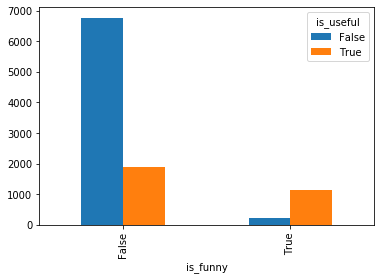

In [0]:
ct1 = pd.crosstab(df.is_funny,df.is_useful)
ct1.plot.bar()

In [0]:
ct1

is_useful,False,True
is_funny,,
False,6771,1874
True,207,1148


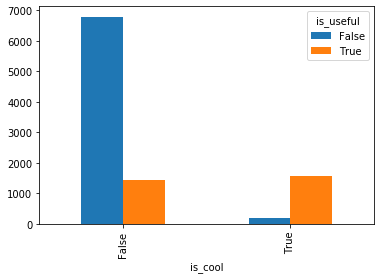

In [0]:
ct2 = pd.crosstab(df.is_cool,df.is_useful)
ct2.plot.bar()


In [0]:
ct2

is_useful,False,True
is_cool,,
False,6795,1450
True,183,1572


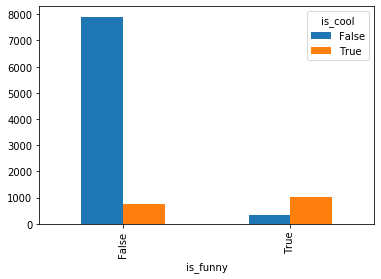

In [0]:
ct3 = pd.crosstab(df.is_funny,df.is_cool)
ct3.plot.bar()

In [0]:
ct3

is_cool,False,True
is_funny,,
False,7909,736
True,336,1019


NameError: ignored

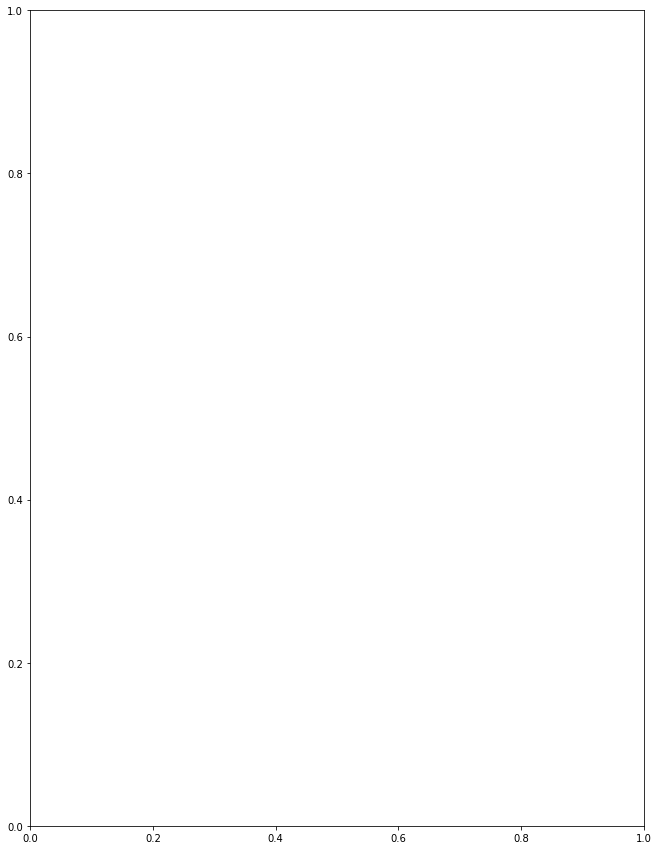

In [0]:
corr = df.corr()
f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 10)
ax.set_xticklabels(corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [0]:
corr = df.corr()
f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 10)
ax.set_xticklabels(corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

NameError: ignored